# Tutorial: warm start from a similar fit

In this tutorial you will learn:

 - How to play with model variations
 - Warm start feature: How UltraNest can resume and reuse an existing run, even if you modified the data/likelihood

As a simple example, lets say we want to fit a black body.

In [1]:
import numpy as np
from numpy import pi, log
import scipy.stats
import matplotlib.pyplot as plt

## Black body model

In [2]:
parameters = ['Temperature', 'Amplitude']

In [3]:
def black_body_model(wavelength, ampl, T):
    with np.errstate(over='ignore'):
        return ampl / wavelength**5 / (np.exp(1/(wavelength*T)) - 1)

## Generate some data

In [4]:
Ndata = 10
wavelength = np.logspace(1, 2, Ndata)

In [5]:
np.random.seed(1)
ampl_true = 42.0
T_true = 0.01  # in um^-1
background_true = 1e-9
y_true = black_body_model(wavelength, ampl_true, T_true)
sigma_true = y_true * 0.1
y_obs = np.random.normal(y_true + background_true, sigma_true, size=Ndata)
sigma = y_true * 0.1

## Visualise the data

Lets plot the data first to see what is going on:



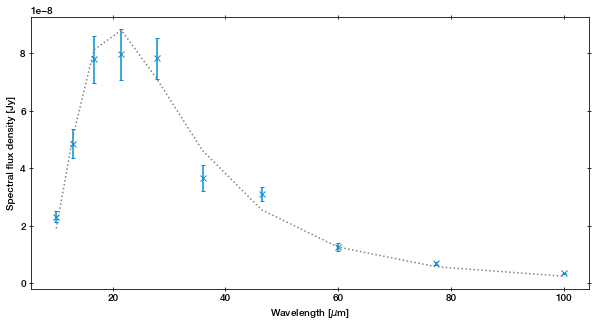

In [6]:
plt.figure(figsize=(10, 5))
plt.errorbar(x=wavelength, y=y_obs, yerr=sigma, marker='x', ls=' ')
plt.plot(wavelength, y_true, ':', color='gray')
plt.ylabel('Spectral flux density [Jy]');
plt.xlabel('Wavelength [$\mu$m]');


## Prior

Here we intentionally set very wide priors:

* a uniform prior on temperature, and 
* a very wide log-uniform prior on the normalisation.

In [7]:
def prior_transform(x):
    z = x.copy()
    z[0] = x[0]
    z[1] = 10**(x[1] * 20 - 10)
    return z


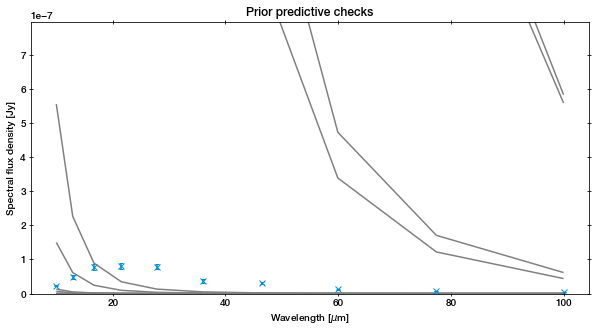

In [8]:
plt.figure(figsize=(10, 5))
plt.title("Prior predictive checks")
plt.errorbar(x=wavelength, y=y_obs, yerr=sigma, marker='x', ls=' ')
plt.ylim(0, y_obs.max() * 10)

for i in range(20):
    T, ampl = prior_transform(np.random.uniform(size=len(parameters)))
    y_predicted = black_body_model(wavelength, ampl, T)
    plt.plot(wavelength, y_predicted, '-', color='gray')
plt.ylabel('Spectral flux density [Jy]');
plt.xlabel('Wavelength [$\mu$m]');


# First simple model

In [9]:
def log_likelihood(params):
    T, ampl = params
    y_predicted = black_body_model(wavelength, ampl, T)
    return scipy.stats.norm(y_predicted, sigma).logpdf(y_obs).sum()


In [19]:
from ultranest import ReactiveNestedSampler

reference_run_folder = 'blackbody-alldata'
sampler_ref = ReactiveNestedSampler(parameters, log_likelihood, prior_transform, log_dir=reference_run_folder, resume='overwrite')
results_ref = sampler_ref.run(frac_remain=0.5)
sampler_ref.print_results()


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=2e+02  7 [173.9132..173.9155]*| it/evals=5960/17596 eff=34.6592% N=400    400 
[ultranest] Likelihood function evaluations: 17598
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 160 +- 0.1753
[ultranest] Effective samples strategy satisfied (ESS = 983.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.14 to 0.51, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.18 tail:0.41 total:0.44 required:<0.50
[ultranest] done iterating.

logZ = 160.064 +- 0.655
  single instance: logZ = 160.064 +- 0.184
  bootstrapped   : logZ = 160.026 +- 0.514
  tail           : logZ = +- 0.405
insert order U test : converged: True correlation: inf iterations

    Temperature         : 0.00940│ ▁▁▁▁▁▁▁▁▁▁▂▂▃▃▅▅▅▅▆▇▇▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁ │0.01033    0.009

## Plot the fit

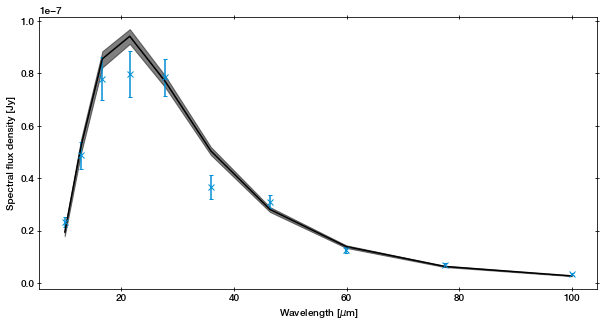

In [20]:
plt.figure(figsize=(10, 5))
plt.errorbar(x=wavelength, y=y_obs, yerr=sigma, marker='x', ls=' ')
from ultranest.plot import PredictionBand
band = PredictionBand(wavelength)
for T, ampl in results_ref['samples']:
    band.add(black_body_model(wavelength, ampl, T))
band.line(color='k')
band.shade(color='k', alpha=0.5)
plt.ylabel('Spectral flux density [Jy]');
plt.xlabel('Wavelength [$\mu$m]');


# Warm Start with Model modification

Lets say we alter our model slightly. We include a small constant background:

In [27]:
def log_likelihood_with_background(params):
    T, ampl = params
    y_predicted = black_body_model(wavelength, ampl, T) + 1e-9
    return scipy.stats.norm(y_predicted, sigma).logpdf(y_obs).sum()


We have the same parameters, and expect results to only be slightly different. So lets use **warm start**.

Using the previous reference run output file ...

In [28]:
posterior_upoints_file = reference_run_folder + '/chains/weighted_post_untransformed.txt'

We define our accelerated likelihood and prior transform:

In [29]:
from ultranest.integrator import warmstart_from_similar_file

aux_paramnames, aux_log_likelihood, aux_prior_transform, vectorized = warmstart_from_similar_file(
    posterior_upoints_file, parameters, log_likelihood_with_background, prior_transform)


Make accelerated run:

In [30]:
sampler = ReactiveNestedSampler(aux_paramnames, aux_log_likelihood, aux_prior_transform, vectorized=vectorized)
res = sampler.run(frac_remain=0.5)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=2e+02  8 [169.3705..169.3741]*| it/evals=1560/4757 eff=35.8045% N=400  
[ultranest] Likelihood function evaluations: 4808
[ultranest]   logZ = 166.7 +- 0.04882
[ultranest] Effective samples strategy satisfied (ESS = 867.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.41, need <0.5)
[ultranest]   logZ error budget: single: 0.07 bs:0.05 tail:0.41 total:0.41 required:<0.50
[ultranest] done iterating.


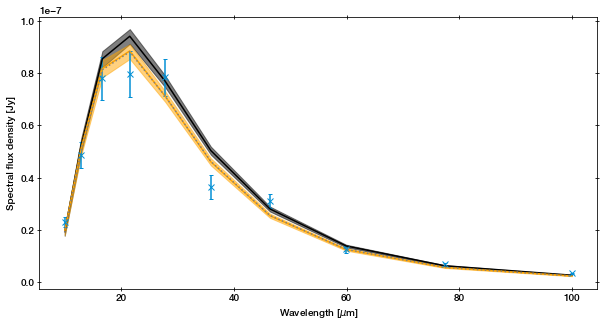

In [31]:
plt.figure(figsize=(10, 5))
plt.errorbar(x=wavelength, y=y_obs, yerr=sigma, marker='x', ls=' ')
from ultranest.plot import PredictionBand
band = PredictionBand(wavelength)
for T, ampl in results_ref['samples']:
    band.add(black_body_model(wavelength, ampl, T))
band.line(color='k')
band.shade(color='k', alpha=0.5)

band = PredictionBand(wavelength)
for T, ampl, _ in res['samples']:
    band.add(black_body_model(wavelength, ampl, T))
band.line(color='orange')
band.shade(color='orange', alpha=0.5)
plt.plot(wavelength, y_true, ':', color='gray')
plt.ylabel('Spectral flux density [Jy]');
plt.xlabel('Wavelength [$\mu$m]');


## Speed-up

In [34]:
print("Speed-up of warm-start: %d%%" % ((results_ref['ncall'] / res['ncall'] - 1)*100))

Speed-up of warm-start: 266%


The cost savings are higher, the more similar the posterior of the modified run is to the original run. This speed-up increases drastically if you have highly informative posteriors.
This benefit is *independent of problem dimension*.

# Starting from existing posterior samples

The hot-starting works by deforming the parameter space. The prior transform function is adjusted, and the adjustment is removed by reweighting the likelihood function, to produce the same posterior.
To make this work, posterior samples from the unit cube space are required. The deformation uses a factorized auxiliary distribution, based on marginal posterior quantiles.

If you already have posterior samples (or can generate samples from posterior means and standard deviations), and you can untransform to unit cube samples, then you can create an appropriate weighted_post_untransformed.txt file.

The weighted_post_untransformed.txt file from a hot-started run cannot be used. This is because it has a deformation already applied.

## Conclusion

Hot start allows accelerated computation based on already knowing the posterior peak approximately. This allows you to:

* vary the data (change the analysis pipeline)
* vary model assumptions 

without needing to start the computation from scratch (potentially costly).

These features are experimental and feedback is appreciated. It is recommended to do a full, clean run to obtain final, reliable results before publication.
